* Seeing the effect adding case18 and case27 to AF cases has on pvalues and AUC values
    * These are cases where they were defined as nonAF, but they have AF during imaging AQ according to Ronak

This notebook is for generating figures for abstract_1 draft for HRS

Using vtk

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats

from hrs_23_figures import *

from sklearn import metrics

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

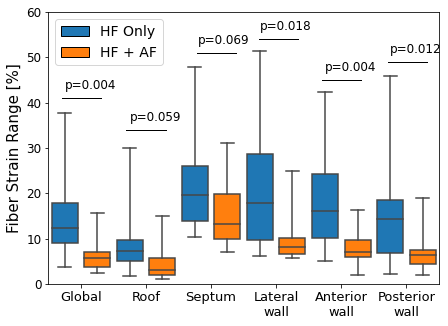

In [3]:
## fibre strain range boxplots across all 5 regions and globally

## Set fibre arch
## Set fibre component
arch='endo_avg'
component=0

## Retrieve data in array
## N_cases, N_regions, N_fcomponents, N_time
nonAF_strains = np.zeros((17,6,2, 10))
AF_strains = np.zeros((12,6,2, 10))

regions = ['global', 'roof', 'sept', 'lat', 'ant', 'post']

for i in range(0,len(regions)):     # region
    for j in range(0,nonAF_strains.shape[0]):    # case
        for k in range(0,2):   # component
            nonAF_strains[j,i,k, :] = retrieve_fibre_strain_transient(nonaf_cases[j], fibre_arch=arch, region=regions[i], component=k)

for i in range(0,len(regions)):     # region
    for j in range(0,AF_strains.shape[0]):    # case
        for k in range(0,2):   # component
            AF_strains[j,i,k, :] = retrieve_fibre_strain_transient(af_cases[j], fibre_arch=arch, region=regions[i], component=k) 

## Get strain ranges
nonAF_ranges = np.ptp(nonAF_strains, axis=3)
AF_ranges = np.ptp(AF_strains, axis=3)

## Plotting

fig, ((ax1)) = plt.subplots(1,1,figsize=(7,5), facecolor='white', sharey=True)

data_to_plot= [nonAF_ranges[:,0,component], AF_ranges[:,0,component],
               nonAF_ranges[:,1,component], AF_ranges[:,1,component],
               nonAF_ranges[:,2,component], AF_ranges[:,2,component],
               nonAF_ranges[:,3,component], AF_ranges[:,3,component],
               nonAF_ranges[:,4,component], AF_ranges[:,4,component],
               nonAF_ranges[:,5,component], AF_ranges[:,5,component]]

sns.boxplot(data=data_to_plot, orient='v', ax=ax1, whis=(0, 100))

regions_axis=['Global', 'Roof', 'Septum', 'Lateral\nwall', 'Anterior\nwall', 'Posterior\nwall']

# ax1.set_ylabel(f"f{component+1} Fibre strain range [%]", fontsize=20)
ax1.set_ylabel(f"Fiber Strain Range [%]", fontsize=15)
ax1.set_xticks(ticks=np.arange(0.5,11.5,2))
ax1.set_xticklabels(regions_axis, fontsize=13)
plt.ylim(0.0, 60)

for i in range(0, 12, 2):
    mybox = ax1.patches[i]
    mybox.set_facecolor('tab:blue')

for i in range(1, 13, 2):
    mybox = ax1.patches[i]
    mybox.set_facecolor('tab:orange')
    
## Calculate p values and plot
p_vals = np.zeros((6,))

for i in range(0, 6):
    ## indexing as follows: p_vals; region; f1 component
    p_vals[i]=stats.ttest_ind(nonAF_ranges, AF_ranges)[-1][i][0]

## Plotting p_values
plt.text(0.0, 43, f'p={str(np.round(p_vals[0],3))}', size=12)
plt.text(2, 36, f'p={str(np.round(p_vals[1],3))}', size=12)
plt.text(4.1, 53, f'p={str(np.round(p_vals[2],3))}', size=12)
plt.text(6, 56, f'p={str(np.round(p_vals[3],3))}', size=12)
plt.text(8, 47, f'p={str(np.round(p_vals[4],3))}', size=12)
plt.text(10, 51, f'p={str(np.round(p_vals[5],3))}', size=12)

## horizontal lines
low_1=0.035
len_line=0.1
plt.axhline(41, low_1,low_1+len_line, c='black', lw=1)

low_2=0.2
low_3=0.38
low_4=0.54
low_5=0.7
low_6=0.87

plt.axhline(34, low_2,low_2+len_line, c='black', lw=1)
plt.axhline(51, low_3,low_3+len_line, c='black', lw=1)
plt.axhline(54, low_4,low_4+len_line, c='black', lw=1)
plt.axhline(45, low_5,low_5+len_line, c='black', lw=1)
plt.axhline(49, low_6,low_6+len_line, c='black', lw=1)

legend_elements = [Patch(facecolor='tab:blue', edgecolor='black',
                         label='HF Only'),
                   Patch(facecolor='tab:orange', edgecolor='black',
                         label='HF + AF')]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=14)

plt.yticks(fontsize=12)

# sns.set_style("whitegrid")

# plt.savefig("/home/csi20/Dropbox/phd/Documents/HRS23/boxplots_1_1_nolines_nopval.png", dpi=200, bbox_inches="tight")

In [26]:
## Regional stats
region=4

print("AF:\t", np.mean(AF_ranges[:,region,component]), "pm", 
     np.std(AF_ranges[:,region,component]))
print("nAF:\t", np.mean(nonAF_ranges[:,region,component]), "pm", 
     np.std(nonAF_ranges[:,region,component]))

AF:	 8.18690122313461 pm 3.8763808067956695
nAF:	 18.79429577039127 pm 10.868858518504853


In [7]:

## Set up prredicts (probs) and ground truth labels for AF
## N_cases, N_region, N_components

y_true = np.zeros((29, 6, 2))
y_true[:17, ...] = 1.0

y_probs = np.zeros((29, 6, 2))
y_probs[:17, ...] = nonAF_ranges[...]
y_probs[17:, ...] = AF_ranges[...]

fpr, tpr, thresholds = metrics.roc_curve(y_true[:, 0, 0], y_probs[:, 0, 0])
auc = metrics.roc_auc_score(y_true[:, 0, 0], y_probs[:, 0, 0])

auc

0.8578431372549019

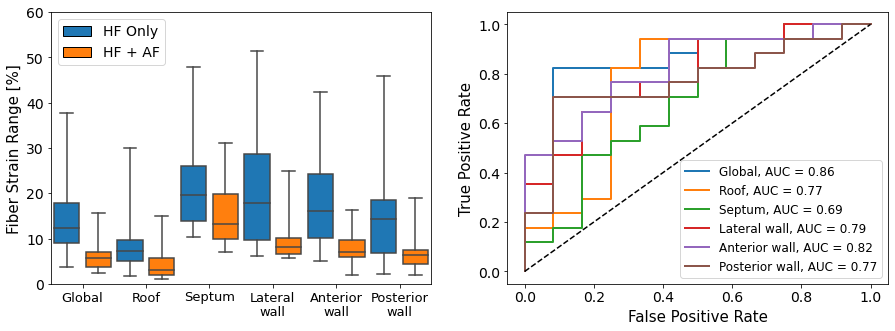

In [8]:
## fibre strain range boxplots across all 5 regions and globally

## Set fibre arch
## Set fibre component
arch='endo_avg'
component=0

## Retrieve data in array
## N_cases, N_regions, N_fcomponents, N_time
nonAF_strains = np.zeros((17,6,2, 10))
AF_strains = np.zeros((12,6,2, 10))

regions = ['global', 'roof', 'sept', 'lat', 'ant', 'post']

for i in range(0,len(regions)):     # region
    for j in range(0,nonAF_strains.shape[0]):    # case
        for k in range(0,2):   # component
            nonAF_strains[j,i,k, :] = retrieve_fibre_strain_transient(nonaf_cases[j], fibre_arch=arch, region=regions[i], component=k)

for i in range(0,len(regions)):     # region
    for j in range(0,AF_strains.shape[0]):    # case
        for k in range(0,2):   # component
            AF_strains[j,i,k, :] = retrieve_fibre_strain_transient(af_cases[j], fibre_arch=arch, region=regions[i], component=k) 

## Get strain ranges
nonAF_ranges = np.ptp(nonAF_strains, axis=3)
AF_ranges = np.ptp(AF_strains, axis=3)

## Plotting

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5), facecolor='white')

data_to_plot= [nonAF_ranges[:,0,component], AF_ranges[:,0,component],
               nonAF_ranges[:,1,component], AF_ranges[:,1,component],
               nonAF_ranges[:,2,component], AF_ranges[:,2,component],
               nonAF_ranges[:,3,component], AF_ranges[:,3,component],
               nonAF_ranges[:,4,component], AF_ranges[:,4,component],
               nonAF_ranges[:,5,component], AF_ranges[:,5,component]]

sns.boxplot(data=data_to_plot, orient='v', ax=ax1, whis=(0, 100))

regions_axis=['Global', 'Roof', 'Septum', 'Lateral\nwall', 'Anterior\nwall', 'Posterior\nwall']

# ax1.set_ylabel(f"f{component+1} Fibre strain range [%]", fontsize=20)
ax1.set_ylabel(f"Fiber Strain Range [%]", fontsize=15)
ax1.set_xticks(ticks=np.arange(0.5,11.5,2))
ax1.set_xticklabels(regions_axis, fontsize=13)
# plt.ylim(0.0, 60)

for i in range(0, 12, 2):
    mybox = ax1.patches[i]
    mybox.set_facecolor('tab:blue')

for i in range(1, 13, 2):
    mybox = ax1.patches[i]
    mybox.set_facecolor('tab:orange')
    
## Calculate p values and plot
p_vals = np.zeros((6,))

for i in range(0, 6):
    ## indexing as follows: p_vals; region; f1 component
    p_vals[i]=stats.ttest_ind(nonAF_ranges, AF_ranges)[-1][i][0]

## Plotting p_values
# plt.text(0.0, 43, f'p={str(np.round(p_vals[0],3))}', size=12)
# plt.text(2, 36, f'p={str(np.round(p_vals[1],3))}', size=12)
# plt.text(4.1, 53, f'p={str(np.round(p_vals[2],3))}', size=12)
# plt.text(6, 56, f'p={str(np.round(p_vals[3],3))}', size=12)
# plt.text(8, 47, f'p={str(np.round(p_vals[4],3))}', size=12)
# plt.text(10, 51, f'p={str(np.round(p_vals[5],3))}', size=12)

## horizontal lines
low_1=0.035
len_line=0.1
# plt.axhline(41, low_1,low_1+len_line, c='black', lw=1)

low_2=0.2
low_3=0.38
low_4=0.54
low_5=0.7
low_6=0.87

# plt.axhline(34, low_2,low_2+len_line, c='black', lw=1)
# plt.axhline(51, low_3,low_3+len_line, c='black', lw=1)
# plt.axhline(54, low_4,low_4+len_line, c='black', lw=1)
# plt.axhline(45, low_5,low_5+len_line, c='black', lw=1)
# plt.axhline(49, low_6,low_6+len_line, c='black', lw=1)

legend_elements = [Patch(facecolor='tab:blue', edgecolor='black',
                         label='HF Only'),
                   Patch(facecolor='tab:orange', edgecolor='black',
                         label='HF + AF')]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=14)
ax1.set_ylim(0.0, 60.0)

ax1.tick_params(axis='y', which='major', labelsize=14)

## Second subplot

regions_axis=['Global', 'Roof', 'Septum', 'Lateral wall', 'Anterior wall', 'Posterior wall']

for i in range(0, len(regions)):
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true[:, i, 0], y_probs[:, i, 0])
    auc = metrics.roc_auc_score(y_true[:, i, 0], y_probs[:, i, 0])
    
    ax2.plot(fpr, tpr, label=f"{regions_axis[i]}, AUC = {str(np.round(auc,2))}", lw='2')
    
ax2.tick_params(axis='both', which='major', labelsize=14)

ax2.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), ls='--', c='black')
ax2.set_xlabel("False Positive Rate", fontsize=15)
ax2.set_ylabel("True Positive Rate", fontsize=15)
ax2.legend(fontsize=12,)

# plt.savefig("/home/csi20/Dropbox/phd/Documents/HRS23/combine_boxplots_auc.png", dpi=200, bbox_inches="tight")

Text(0.6, 0.5, 'AUC = 0.77')

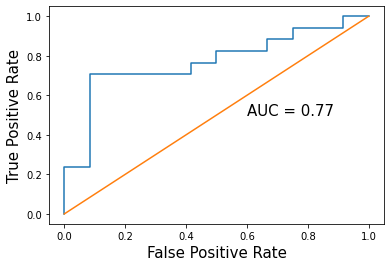

In [9]:
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))

plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)

plt.text(0.6, 0.5, f'AUC = {str(np.round(auc,3))}', size=15)

In [10]:
for i in range(0, len(regions)):
    auc = metrics.roc_auc_score(y_true[:, i, 0], y_probs[:, i, 0])
    
    print(f"{regions[i]} AUC: ", auc)

global AUC:  0.8578431372549019
roof AUC:  0.7696078431372548
sept AUC:  0.6911764705882353
lat AUC:  0.7941176470588236
ant AUC:  0.823529411764706
post AUC:  0.7696078431372549


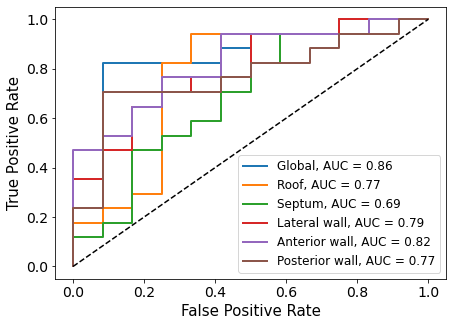

In [11]:
## Plotting all 6 lines on same plot

fig, ((ax1)) = plt.subplots(1,1,figsize=(7,5), facecolor='white', sharey=True)

regions_axis=['Global', 'Roof', 'Septum', 'Lateral wall', 'Anterior wall', 'Posterior wall']

for i in range(0, len(regions)):
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true[:, i, 0], y_probs[:, i, 0])
    auc = metrics.roc_auc_score(y_true[:, i, 0], y_probs[:, i, 0])
    
    plt.plot(fpr, tpr, label=f"{regions_axis[i]}, AUC = {str(np.round(auc,2))}", lw='2')
    
#     print(len(fpr))
#     print(len(tpr))

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), ls='--', c='black')
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=12)

# plt.text(0.6, 0.5, f'AUC = {str(np.round(auc,3))}', size=15)
# plt.savefig("/home/csi20/Dropbox/phd/Documents/HRS23/roc_analysis_1_1.png", dpi=200, bbox_inches="tight")

## Ejection fractions

In [12]:
f20_cases

['CT-CRT/case21',
 'CT-CRT/case23',
 'CT-CRT/case24',
 'CT-CRT/case25',
 'CT-CRT/case26',
 'CT-CRT/case27',
 'CT-CRT/case28',
 'CT-CRT/case29',
 'CT-CRT/case30',
 'CT-CRT/case31',
 'CT-CRT/case32',
 'CT-CRT/case34',
 'EBR/case01',
 'EBR/case02']

Ttest_indResult(statistic=0.21566136076274375, pvalue=0.830872631368488)


(0.0, 60.0)

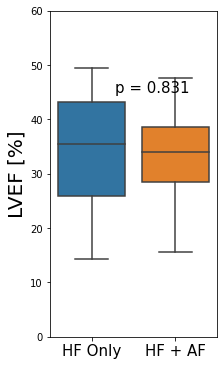

In [13]:
numTimes = 10
nTime=np.arange(0, numTimes)/numTimes

DataPath="/home/csi20/Dropbox/phd/Data/RG_CT_Cases"
# DataPath="/media/csi20local/Seagate Portable Drive/Master/Data/RG_CT_Cases"

# f20_cases = ['21', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '34']
# f20_cases = [f'CT-CRT/case{case_ind}' for case_ind in f20_cases]
# ebr=['EBR/case01', 'EBR/case02']
# f20_cases = f20_cases + ebr

## All 30 Cases

# # nonAF
# nonaf_cases = ['01', '02', '05', '06', '07', '08', '09', '12', '14',
#              '15', '16', '17', '18', '24', '27', '28', '29', '30', '32']
# nonaf_cases = [f"CT-CRT/case{case}" for case in nonaf_cases]


# # AF
# af_cases = ['10', '19', '20', '23', '25', '26', '31', '34']
# af_cases = [f'CT-CRT/case{case}' for case in af_cases]
# af_cases = af_cases + ebr

## 07 and 10 failed with haonet

nAF_LV_EF = np.zeros((len(nonaf_cases),))
AF_LV_EF = np.zeros((len(af_cases),))

## append data

# basePath="/media/csi20local/Seagate Portable Drive/Master/Data/RG_CT_Cases"
basePath="/home/csi20/Dropbox/phd/Data/RG_CT_Cases"

for i in range(0, len(nonaf_cases)):
    nAF_LV_EF[i] = np.loadtxt(f"{basePath}/{nonaf_cases[i]}/multilabel_seg_analysis/LV_EF.txt")
    
for i in range(0, len(af_cases)):
    AF_LV_EF[i] = np.loadtxt(f"{basePath}/{af_cases[i]}/multilabel_seg_analysis/LV_EF.txt")

### Doing the plotting

fig, (ax1) = plt.subplots(1,1,figsize=(3,6), facecolor='white', sharey=True)

sns.boxplot(data=[nAF_LV_EF, AF_LV_EF], orient='v')
plt.ylabel("LVEF [%]", fontsize=20)
plt.xticks(np.arange(2), ['HF Only', 'HF + AF'], fontsize=15)
# plt.ylim(0,45)

print(stats.ttest_ind(nAF_LV_EF, AF_LV_EF))
pval = stats.ttest_ind(nAF_LV_EF, AF_LV_EF)[-1]
plt.text(0.28, 45, f'p = {str(np.round(pval,3))}', size=15)

plt.ylim(0,60.0)

# plt.savefig("/home/csi20/Dropbox/phd/Documents/HRS23/lv_ef_1_notxt.png",dpi=200, facecolor=fig.get_facecolor(), bbox_inches='tight')    

Ttest_indResult(statistic=4.5312584083396965, pvalue=0.00010730573190481908)


Text(0.28, 80, 'p = 0.0')

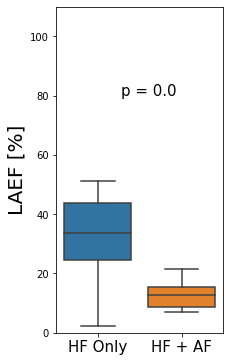

In [14]:
nAF_LA_EF = np.zeros((len(nonaf_cases),))
AF_LA_EF = np.zeros((len(af_cases),))

basePath="/media/csi20local/Seagate Portable Drive/Master/Data/RG_CT_Cases"
basePath="/home/csi20/Dropbox/phd/Data/RG_CT_Cases"

for i in range(0, len(nonaf_cases)):
    nAF_LA_EF[i] = np.loadtxt(f"{basePath}/{nonaf_cases[i]}/multilabel_seg_analysis/LA_EF.txt")
    
for i in range(0, len(af_cases)):
    AF_LA_EF[i] = np.loadtxt(f"{basePath}/{af_cases[i]}/multilabel_seg_analysis/LA_EF.txt")
    

## Plotting

fig, (ax1) = plt.subplots(1,1,figsize=(3,6), facecolor='white', sharey=True)

sns.boxplot(data=[nAF_LA_EF, AF_LA_EF], orient='v')
plt.ylabel("LAEF [%]", fontsize=20)
plt.xticks(np.arange(2), ['HF Only', 'HF + AF'], fontsize=15)
plt.ylim(0,110)

print(stats.ttest_ind(nAF_LA_EF, AF_LA_EF))
pval = stats.ttest_ind(nAF_LA_EF, AF_LA_EF)[-1]
plt.text(0.28, 80, f'p = {str(np.round(pval,3))}', size=15)

# plt.savefig("/home/csi20/Dropbox/phd/Documents/HRS23/la_ef_1.png",dpi=200, facecolor=fig.get_facecolor(), bbox_inches='tight')

Ttest_indResult(statistic=0.21566136076274375, pvalue=0.830872631368488)


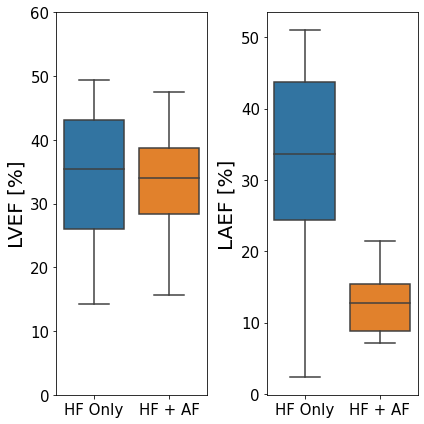

In [15]:
numTimes = 10
nTime=np.arange(0, numTimes)/numTimes

DataPath="/home/csi20/Dropbox/phd/Data/RG_CT_Cases"
# DataPath="/media/csi20local/Seagate Portable Drive/Master/Data/RG_CT_Cases"

nAF_LV_EF = np.zeros((len(nonaf_cases),))
AF_LV_EF = np.zeros((len(af_cases),))

## append data

# basePath="/media/csi20local/Seagate Portable Drive/Master/Data/RG_CT_Cases"
basePath="/home/csi20/Dropbox/phd/Data/RG_CT_Cases"

for i in range(0, len(nonaf_cases)):
    nAF_LV_EF[i] = np.loadtxt(f"{basePath}/{nonaf_cases[i]}/multilabel_seg_analysis/LV_EF.txt")
    
for i in range(0, len(af_cases)):
    AF_LV_EF[i] = np.loadtxt(f"{basePath}/{af_cases[i]}/multilabel_seg_analysis/LV_EF.txt")

### Doing the plotting

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,6), facecolor='white')

sns.boxplot(data=[nAF_LV_EF, AF_LV_EF], orient='v', ax=ax1)
ax1.set_ylabel("LVEF [%]", fontsize=20)
ax1.set_xticks(np.arange(2), ['HF Only', 'HF + AF'], fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15)
# plt.ylim(0,45)

print(stats.ttest_ind(nAF_LV_EF, AF_LV_EF))
pval = stats.ttest_ind(nAF_LV_EF, AF_LV_EF)[-1]
# plt.text(0.28, 45, f'p = {str(np.round(pval,3))}', size=15)

ax1.set_ylim(0,60.0)

sns.boxplot(data=[nAF_LA_EF, AF_LA_EF], orient='v', ax=ax2)
ax2.set_ylabel("LAEF [%]", fontsize=20)
ax2.set_xticks(np.arange(2), ['HF Only', 'HF + AF'], fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
# plt.ylim(0,110)

# print(stats.ttest_ind(nAF_LA_EF, AF_LA_EF))
# pval = stats.ttest_ind(nAF_LA_EF, AF_LA_EF)[-1]
# plt.text(0.28, 80, f'p = {str(np.round(pval,3))}', size=15)

plt.tight_layout()


# plt.savefig("/home/csi20/Dropbox/phd/Documents/HRS23/ef_combines.png",dpi=200, facecolor=fig.get_facecolor(), bbox_inches='tight')    